# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Афанасьева".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.


Минимизируем функцию потерь: 
$$
h\left(x^{(i)}, w\right) = \sigma(w^{T} x^{(i)} + w_0) = \frac{1}{1 + e^{-(w^{T}x^{(i)} + w_0)}}\\
$$
$$ L(w_0,w_1,\dots) = 
- \sum_{i=0}^{n} \Big(y^{(i)} \log\left(h\left(x^{(i)}, w\right)\right)
+  \left(1 - y^{(i)}\right) \log\left(1 - h\left(x^{(i)}, w\right)\right)\Big)
+ \frac{1}{C}\sum_{j=1}^{m}\left(w_j\right)^2 
$$
Градиент функции потерь с L2 регуляризацией
$$ \frac{\partial L}{\partial w_j} = \sum_{i=0}^{n} \Big( 
\frac{x_{j}}{1 + e^{w^{T}x^{(i)} + w_0}} -y^{(i)} x_{j}
\Big) + \frac{2}{C}w_j  = \sum_{i=0}^{n}  x_{j} \Big( h\left(x^{(i)}, w\right)
-y^{(i)}
\Big) + \frac{2}{C}w_j $$

In [4]:
def sigmoid(z): 
    return 1./(1 + np.exp(-z))

## Имплементация (5 баллов)

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        batch_size - размер части (мини батча)
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
    
    def h (self, x_elem):
        return sigmoid(-1 * x_elem.dot(self.w))
        
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1) 
        self.errors = []
        self.w = np.ones(x.shape[1])
        
        def grad(x, y_val):
            return x * (self.h(x) - y_val)

        def error(x, y):
            error = 0
            for i in range(x.shape[0]):
                error -= np.log(self.h(x[i])) * y[i] + (1 - np.log(self.h(x[i]))) * (1 - y[i])
            return error
        
        for epoch_num in range(1, self.max_epoch + 1):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            descending_coeff = self.alpha / epoch_num
                        
            for batch_num in range(0, self.batch_size):
                curr_indices = indices[batch_num:batch_num + self.batch_size]
                for i in curr_indices:
                    self.w = self.w + descending_coeff * grad(x[i], y[i])
                    for idx_w in range(self.w.shape[0]):   
                        self.w[idx_w] -= 2.0 / self.C * descending_coeff * self.w[idx_w] # add L2 error
            self.errors.append(error(x, y))
        
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = []
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        for i in range(x.shape[0]):
            if self.h(x[i]) > 0.5:
                y_hat.append(1)
            else:
                y_hat.append(0)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = []
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        for i in range (x.shape[0]):
            y_hat_proba.append (self.h(x[i]))
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

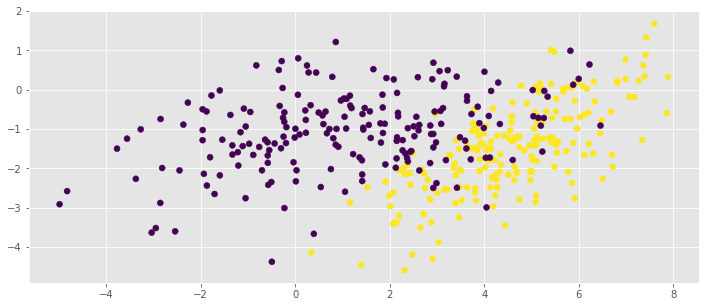

In [6]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [11]:
model = MySGDClassifier(C=200, alpha=0.01, batch_size=100, max_epoch=300)
model.fit(X, y)
result = model.predict(X)
accuracy_score(y_true=y, y_pred=result)

0.89249999999999996

[-0.48411085  0.33757574  1.50773333]


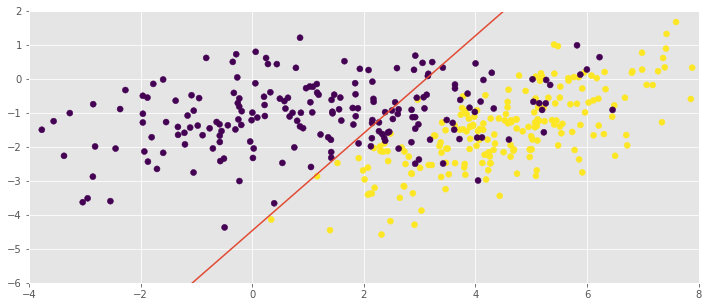

In [8]:
## Your Code Here
print model.w
plt.plot ([-4,8], [(4 * model.w[0] - model.w[2]) / model.w[1], (-8* model.w[0] - model.w[2]) / model.w[1]])
plt.scatter(X[:,0], X[:,1], c=y)
axes = plt.gca()
axes.set_xlim([-4,8])
axes.set_ylim([-6,2])
plt.show ()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [12]:
from sklearn.datasets import make_classification

In [13]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [ ]:
## Your Code Here
for alpha in (0.01, 0.05, 0.1, 0.2):
    model = MySGDClassifier(alpha=alpha, max_epoch=300, C=200, batch_size=10)
    model.fit(X, y)
    plt.plot(model.errors, label='alpha: ' + str(alpha))
plt.ylabel('error value')
plt.xlabel('epoch')
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [ ]:
## Your Code Here
params = np.empty([10, X.shape[1]+1])
for i, c in enumerate(np.logspace(3, -3, 10)):
    model = MySGDClassifier(alpha=0.01, C=c, max_epoch=100)
    model.fit(X, y)
    params[i] = model.w

In [ ]:
for i in range(params.shape[1]):
    lbl = r'w_{}'.format(i)
    plt.plot(np.logspace(3, -3, 10), params[:, i], label=r'$w_{%d}$' % i)
    plt.xscale('log')
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
## Youd Code Here
opponent_unique_cards = df_data.opponent_hero_card_id.unique()
player_unique_cards = df_data.player_hero_card_id.unique()

print "unique opponent cards: ", len(opponent_unique_cards)
print "unique player cards: ", len(player_unique_cards)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

player_values_test = enc.fit_transform(
    df_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_unique_cards.shape[0] + 1)]
df_train_data = pd.concat([df_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_data.index)],
                           axis=1)

df_train_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [ ]:
df_train_data.head().T

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [ ]:
## Youd Code Here
X = df_train_data.drop ('decision', axis=1)
y = df_train_data.decision.values

#model = MySGDClassifier(alpha=0.1, max_epoch=10, C=200, batch_size=10)
#model.fit (X, y)
#print model.w
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sclaer = StandardScaler()
model = MySGDClassifier(alpha=0.001, max_epoch=10, C=200, batch_size=10)

scale_model = Pipeline([('scaler', scaler), ('model', model)])
scale_model.fit(X, y)

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
## Youd Code Here
filepath = 'testData_tabular.csv'
df_test_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_test_data.shape

In [ ]:
# для удобства
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

In [ ]:
df_test_data.head().T

In [ ]:
opponent_unique_cards = df_test_data.opponent_hero_card_id.unique ()
player_unique_cards = df_test_data.player_hero_card_id.unique ()

enc = OneHotEncoder()
player_values_test = enc.fit_transform(
    df_test_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_test_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_unique_cards.shape[0] + 1)]
df_test_modified_data = pd.concat([df_test_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_test_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_test_data.index)],
                           axis=1)

df_test_modified_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [ ]:
df_test_modified_data.head().T

In [ ]:
X_test = df_test_modified_data.drop ('decision', axis=1)

scores = model.predict_proba(X_test)
scores

In [ ]:
from sklearn.metrics import roc_auc_score

y_test = np.loadtxt('deprecated_testLabels.txt')

print 'ROC_AUC:', roc_auc_score(y_test, scores)